In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn import metrics

In [5]:
import opendatasets as od 
import pandas 
  
od.download( 
    "https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: adiiifs
Your Kaggle Key: ········


100%|█████████████████████████████████████████████████████████████████████████████| 1.76G/1.76G [02:48<00:00, 11.2MB/s]


In [6]:
path = 'lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes


['lung_aca', 'lung_n', 'lung_scc']

In [7]:
for cat in classes:
    img_path=f'{path}/{cat}'
    image=os.listdir(img_path)
    print(f'{cat} has {len(image)}')

lung_aca has 5000
lung_n has 5000
lung_scc has 5000


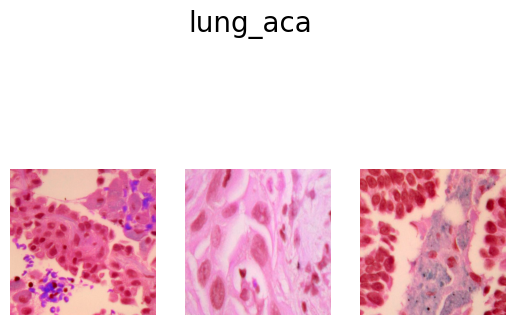

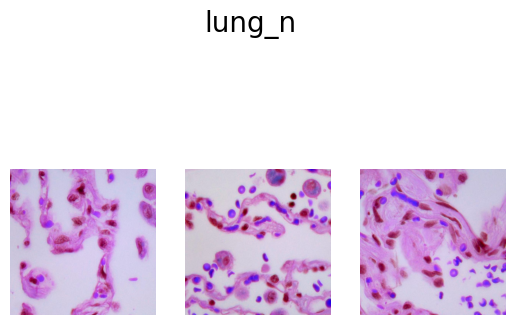

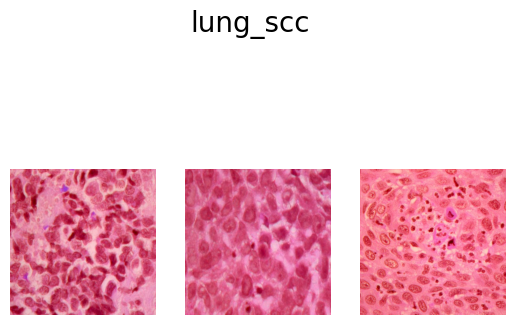

In [8]:
for cat in classes:
    img_path=f'{path}/{cat}'
    image=os.listdir(img_path)
    fig,ax=plt.subplots(1,3)
    plt.suptitle(f'{cat}',fontsize=20)
    for i in range(3):
        k=np.random.randint(0,len(image))
        img=np.array(cv2.imread(f'{path}/{cat}/{image[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [9]:
x=[]
y=[]
for i,cat in enumerate(classes):
    images=glob(f'{path}/{cat}/*.jpeg')
    for image in images:
        img=cv2.imread(image)
        x.append(cv2.resize(img,(256,256)))
        y.append(i)

In [10]:
x = np.asarray(x)

In [11]:
y_dummie=pd.get_dummies(y)

In [38]:
x_train,x_test,y_train,y_test=train_test_split(x,y_dummie,test_size=0.2)
print(x_train.shape, x_test.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


In [39]:
print(y_train.shape, y_test.shape)

(12000, 3) (3000, 3)


In [107]:
cnn=Sequential()

In [108]:
cnn.add(Conv2D(filters=32,kernel_size=(5,5),activation='relu',input_shape=(256, 256, 3), padding='same'))

In [109]:
cnn.add(MaxPool2D(2,2))

In [110]:
cnn.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu', padding='same'))

In [111]:
cnn.add(MaxPool2D(2,2))

In [112]:
cnn.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu', padding='same'))

In [113]:
cnn.add(MaxPool2D(2,2))

In [114]:
cnn.add(Flatten())

In [115]:
cnn.add(Dense(256,activation='relu'))

In [116]:
cnn.add(BatchNormalization())

In [117]:
cnn.add(Dense(128,activation='relu'))

In [118]:
cnn.add(Dropout(0.3))

In [119]:
cnn.add(BatchNormalization())

In [120]:
cnn.add(Dense(3,activation='softmax'))

In [122]:
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 32, 32, 128)      

In [123]:
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [124]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
 
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True
 
 
es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)
 
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [125]:
history=cnn.fit(x_train, y_train,
                    validation_data = (x_test, y_test),
                    batch_size = 64,
                    epochs = 10,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])

Epoch 1/10
188/188 [==============================] - 857s 5s/step - loss: 0.3855 - accuracy: 0.8440 - val_loss: 16.2597 - val_accuracy: 0.3383 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 812s 4s/step - loss: 0.2508 - accuracy: 0.8996 - val_loss: 0.5807 - val_accuracy: 0.8293 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - ETA: 0s - loss: 0.1972 - accuracy: 0.9199
 Validation accuracy has reached upto                       90% so, stopping further training.
188/188 [==============================] - 809s 4s/step - loss: 0.1972 - accuracy: 0.9199 - val_loss: 0.2420 - val_accuracy: 0.9120 - lr: 0.0010


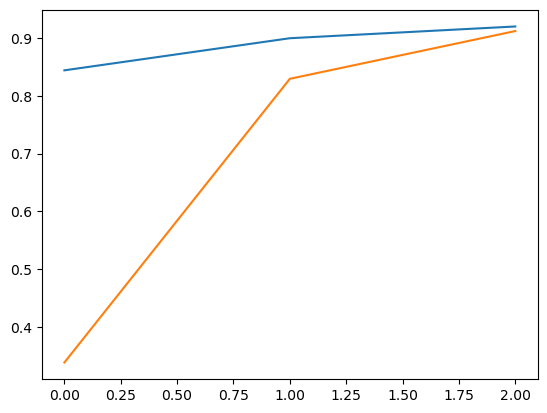

In [126]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

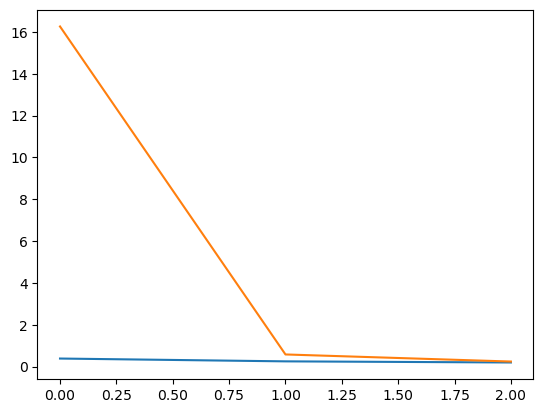

In [127]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

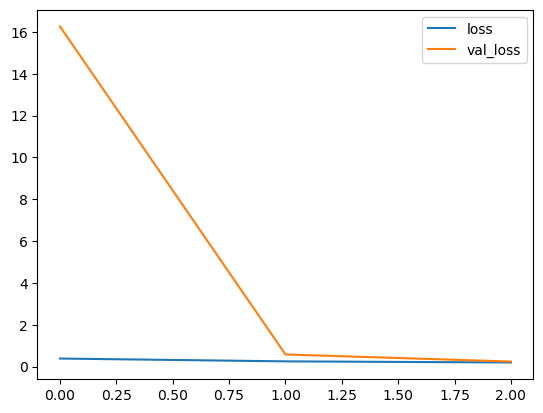

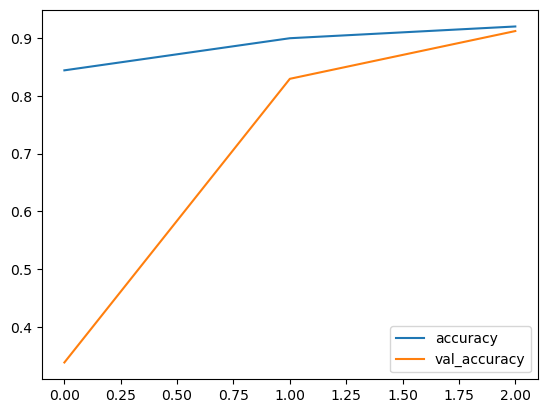

In [128]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [159]:
y_pred=cnn.predict(x_test)

94/94 [==============================] - 29s 306ms/step


In [160]:
y_test_test = y_test.values

In [161]:
y_test_test = np.argmax(y_test_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [162]:
metrics.confusion_matrix(y_test_test, y_pred)

array([[ 793,   55,  128],
       [   2, 1013,    0],
       [  79,    0,  930]], dtype=int64)

In [163]:
print(metrics.classification_report(y_test_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

    lung_aca       0.91      0.81      0.86       976
      lung_n       0.95      1.00      0.97      1015
    lung_scc       0.88      0.92      0.90      1009

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000

